# Setup

Explaining and Harnessing Adversarial Examples https://arxiv.org/pdf/1412.6572


In [ ]:
!pip install -q lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 10.6 MB/s eta 0:00:00


# ENV

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import lightning as L
from tqdm.auto import tqdm

from einops.layers.torch import Reduce, Rearrange
from einops import reduce, rearrange, repeat, einsum, parse_shape, pack, unpack

In [ ]:
import seaborn as sns
sns.set()

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['lines.linewidth']=2

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

In [ ]:
L.seed_everything(42)

torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

torch.autograd.set_detect_anomaly(True)

device='cuda' if torch.cuda.is_available() else 'cpu'
device

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


'cpu'

# Data

In [ ]:
import urllib.request

url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
path = 'image.jpg'
urllib.request.urlretrieve(url, path)


url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
file_path = "labels.txt"
urllib.request.urlretrieve(url, file_path)

('labels.txt', <http.client.HTTPMessage at 0x794743e24af0>)

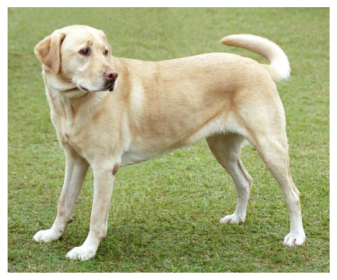

In [ ]:
from PIL import Image

image=Image.open('image.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
with open("labels.txt", "r") as f:
    labels = [s.strip() for s in f.readlines()]

# Architecture

In [ ]:
from torchvision.models import mobilenet_v2,MobileNet_V2_Weights

model=mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
model.eval()
num_classes=model.classifier[1].out_features
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 72.4MB/s]


In [ ]:
from torchvision import transforms

transform=transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image=transform(image)

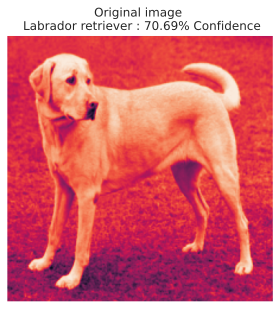

In [ ]:
def display_images(image, description):
    logits=model(image[None,:,:,:])
    prob=logits.softmax(dim=-1)
    label_idx=prob.argmax(dim=-1)[0].item()
    label=labels[label_idx]
    confidence = prob[0, label_idx]


    plt.figure()
    plt.axis('off')
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                label, confidence*100))
    plt.show()

display_images(image,'Original image')

# Test

black stork


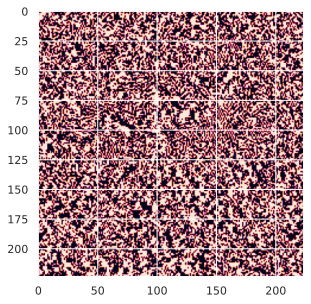

In [ ]:
def create_noise(image, label):
    pred=model(image[None,:,:,:])
    loss=F.cross_entropy(pred, label)

    loss.backward()
    signed_grad = image.grad.sign()
    return signed_grad

target_class=128
print(labels[target_class])
label=torch.zeros(1, num_classes)
label[0][target_class]=1

perturbations=create_noise(nn.Parameter(image), label)
plt.imshow(perturbations[0] * 0.5 + 0.5)

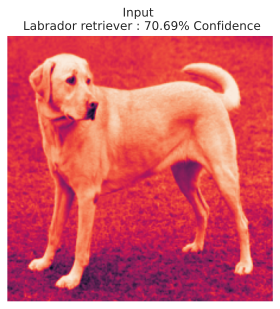

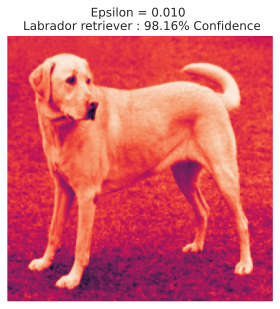

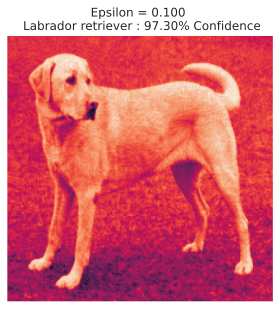

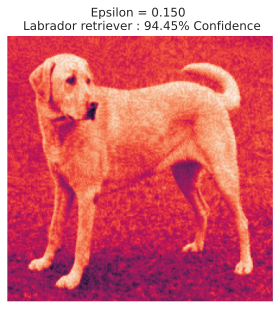

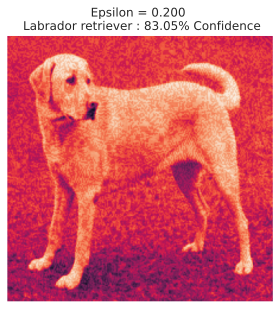

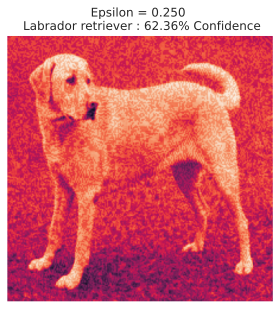

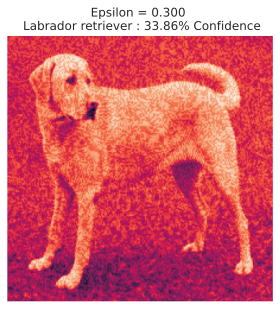

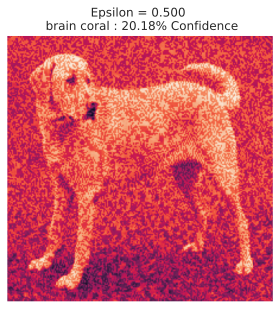

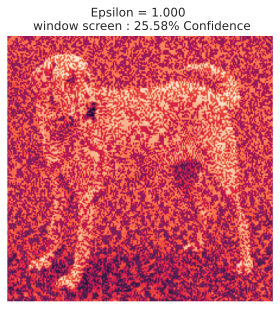

In [ ]:
import torch

epsilons = [0, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps * perturbations
    # adv_x = torch.clamp(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])